## 1. Try with using extract Signal after clustering

In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import normalized_mutual_info_score as nmi

from SigMA.SigMA import SigMA
from helpers import encode_labels_by_frequency, align_ref_to_sigma

import DistantSigMA.misc.utilities as ut

from NoiseRemoval.RemoveNoiseTransformed import remove_noise_simple
from scipy.sparse.csgraph import connected_components


In [21]:
def extract_signal(clusterer):
    labels = clusterer.labels_
    labels_with_noise = -np.ones(clusterer.X.shape[0], dtype=int)
    data_idx = np.arange(labels_with_noise.shape[0])
    for i, u_cl in enumerate(np.unique(labels[labels>-1])):
        cluster_bool_array = remove_noise_simple(labels==u_cl, te_obj=clusterer)
        if cluster_bool_array is not None:
            labels_with_noise[cluster_bool_array] = i
            continue
        else:
            rho = clusterer.weights_[labels == u_cl]
            mad = np.median(np.abs(rho - np.median(rho)))
            threshold = np.median(rho)*0.99 + 3 * mad * 1.1
            # Statistisch fundierterer cut
            # threshold = np.median(rho) + 3 * mad
            cluster_bool_array = rho > threshold
        # Remove noise
        idx_cluster = data_idx[labels==u_cl][cluster_bool_array]
        if len(idx_cluster) > 20:
            # labels_with_noise[idx_cluster] = i
            # Only graph connected points allowed
            _, cc_idx = connected_components(clusterer.A[idx_cluster, :][:, idx_cluster])
            # Combine CCs data points with originally defined dense core (to not miss out on potentially dropped points)
            cluster_indices = data_idx[idx_cluster][cc_idx == np.argmax(np.bincount(cc_idx))]
            labels_with_noise[np.isin(data_idx, cluster_indices)] = i

    return labels_with_noise

In [22]:
# Paths
output_path = ut.set_output_path(script_name="DeNoise")

run = "DeNoise_pruning"
output_path = output_path + f"{run}/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [23]:
# ---------------------------------------------------------
# Load data
mock_df = pd.read_csv("/Users/alena/PycharmProjects/Distant_SigMA/Data/Mock/Box_0_with_all_clustering_results.csv")


data = mock_df.loc[mock_df['parallax']>0]
data = data.loc[data['parallax']/data['parallax_error']>4.5].reset_index(drop=True)

# ---------------------------------------------------------
# Clustering in XYZ and tangential velocity space
pm_axes = ['pmra', 'pmdec']
# v_tan_axes = ['v_a_lsr', 'v_d_lsr']  # tangential velocity in LSR

# Clustering in XYZ and UVW space
xyz_axes = ['ra', 'dec', 'parallax']
# uvw_axes = ['U', 'V', 'W']


cluster_features = xyz_axes + pm_axes
scale_factors = {'vel': {'features': ['parallax'], 'factor': 0.2}}

sigma_kwargs = dict(
    cluster_features=cluster_features,
    scale_factors=scale_factors,
    # These are the default values and should be kept for now
    nb_resampling=0, max_knn_density=101,
    beta=0.99, knn_initcluster_graph=45,
    do_remove_edges=True
)

clusterer = SigMA(data=data, **sigma_kwargs).fit(alpha=0.05, knn=15, bh_correction=True)

Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 1.00e-05


In [24]:
labels_with_noise = extract_signal(clusterer)

In [25]:
nmi(data.labels, labels_with_noise)

np.float64(0.12155749479256885)

In [26]:
np.unique(labels_with_noise)


array([-1, 14, 21])

### -> Only 3 clusters remain!

# 2. Try to use connected components on noisy solution

In [27]:
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
from helpers import encode_labels_by_frequency, align_ref_to_sigma, noisy_solution, analyze_solution

In [28]:
print("NMI: ", nmi(data.labels, clusterer.labels_))

rho = clusterer.weights_

label_rho_df = pd.DataFrame(data=np.stack([clusterer.labels_, rho, data.labels.to_numpy()], axis=1), columns=["labels_SigMA", "density", "reference"])
label_rho_df.labels_SigMA = label_rho_df.labels_SigMA.astype(int)

big_df = pd.concat([data, label_rho_df], axis=1)

print(big_df.shape, label_rho_df.shape)

big_df["real_ref"] = encode_labels_by_frequency(big_df.reference)
print("NMI: ", nmi(big_df.real_ref, big_df.labels_SigMA))
big_df_aligned = align_ref_to_sigma(input_data=big_df,ref_label="real_ref", label2match="labels_SigMA", new_col_name="labels_SigMA_aligned")
print("NMI: ", nmi(big_df_aligned.real_ref, big_df_aligned.labels_SigMA))

big_df_aligned.loc[:, "scaled_parallax"] = big_df_aligned["parallax"] * 0.2

NMI:  0.9612101676584978
(57622, 36) (57622, 3)
NMI:  0.9612101676584976
NMI:  0.9612101676584976


In [29]:
big_df_aligned.index

RangeIndex(start=0, stop=57622, step=1)

In [30]:
data = noisy_solution(p=0.5,
                      input_data=big_df_aligned,
                      reference_labels="real_ref",
                      clustered_labels="labels_SigMA_aligned",
                      new_label_col="SigMA_noisy")


data.sort_values(by="SigMA_noisy", inplace=True)

In [41]:
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import numpy as np

def prune_connected_components(
    df_in,
    label_col,
    unique_labels,
    adjacency_matrix,
    max_components_to_keep=1
):
    df = df_in.copy()
    df["SigMA_noisy_pruned"] = df[label_col]  # initialize once

    for lbl in unique_labels:
        cluster = df[df[label_col] == lbl]
        indices = cluster.index.to_list()

        A_sub = adjacency_matrix[np.ix_(indices, indices)]
        graph_sub = csr_matrix(A_sub)
        n_components, c_lab = connected_components(graph_sub, directed=False, return_labels=True)

        if n_components == 0:
            continue

        component_labels = np.array(c_lab)
        unique_components, counts = np.unique(component_labels, return_counts=True)

        # Filter out components of size 1
        large_components = [(comp, count) for comp, count in zip(unique_components, counts) if count > 1]

        # If no large components, skip
        if len(large_components) == 0:
            mask_to_update = (df[label_col] == lbl)
            df.loc[mask_to_update, "SigMA_noisy_pruned"] = -1
            print(f"Label {lbl} — all components too small (size 1), everything pruned.")
            continue

        # Sort by size descending
        large_components.sort(key=lambda x: x[1], reverse=True)

        # Keep up to N largest
        top_components = [comp for comp, _ in large_components[:max_components_to_keep]]

        # Collect indices to keep
        indices_to_keep = set()
        for comp_id in top_components:
            print(type(np.where(component_labels == comp_id)))
            member_positions = np.where(component_labels == comp_id)[0]
            indices_to_keep.update(indices[i] for i in member_positions)

        # Prune all others
        mask_to_update = (df[label_col] == lbl) & (~df.index.isin(indices_to_keep))
        df.loc[mask_to_update, "SigMA_noisy_pruned"] = -1

        print(f"Label {lbl} — Original: {len(indices)}, Kept: {len(indices_to_keep)}, Pruned: {np.sum(mask_to_update)}")

    return df



In [42]:
unique_labels = data.SigMA_noisy.unique()

df_pruned = prune_connected_components(df_in=data, label_col="SigMA_noisy", unique_labels=unique_labels, adjacency_matrix=clusterer.A,
max_components_to_keep=1,
)

<class 'tuple'>
Label -1 — Original: 17642, Kept: 17641, Pruned: 1
<class 'tuple'>
Label 0 — Original: 2354, Kept: 1747, Pruned: 607
<class 'tuple'>
Label 1 — Original: 2018, Kept: 1427, Pruned: 591
<class 'tuple'>
Label 2 — Original: 1840, Kept: 1214, Pruned: 626
<class 'tuple'>
Label 3 — Original: 1831, Kept: 1249, Pruned: 582
<class 'tuple'>
Label 4 — Original: 1861, Kept: 1268, Pruned: 593
<class 'tuple'>
Label 5 — Original: 1775, Kept: 1195, Pruned: 580
<class 'tuple'>
Label 6 — Original: 1655, Kept: 1104, Pruned: 551
<class 'tuple'>
Label 7 — Original: 1633, Kept: 1058, Pruned: 575
<class 'tuple'>
Label 8 — Original: 1530, Kept: 915, Pruned: 615
<class 'tuple'>
Label 9 — Original: 1516, Kept: 916, Pruned: 600
<class 'tuple'>
Label 10 — Original: 1556, Kept: 959, Pruned: 597
<class 'tuple'>
Label 11 — Original: 1397, Kept: 831, Pruned: 566
<class 'tuple'>
Label 12 — Original: 1391, Kept: 793, Pruned: 598
<class 'tuple'>
Label 13 — Original: 1396, Kept: 796, Pruned: 600
<class 'tup

/opt/miniconda3/envs/SigMA_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/SigMA_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/miniconda3/envs/SigMA_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



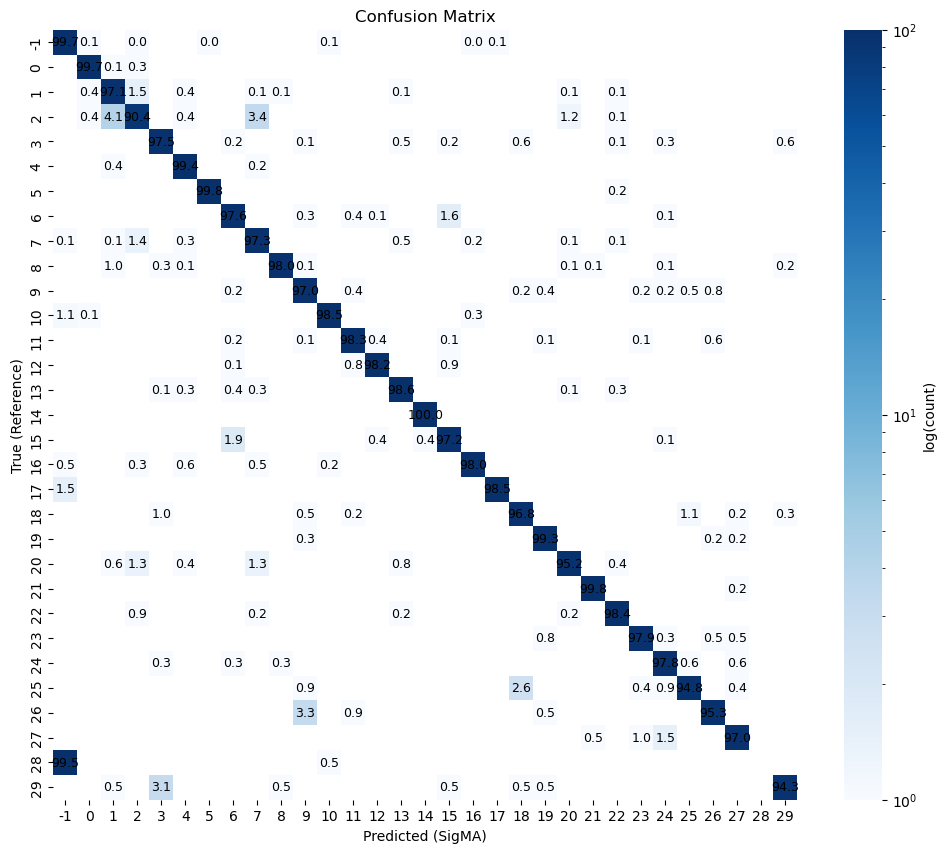

In [33]:
rep,fig = analyze_solution(df_pruned, "real_ref", "SigMA_noisy_pruned")

In [34]:
rep

,precision,recall,f1-score,support
-1,0.993724,0.996539,0.995129,34957.000000
0,0.980538,0.996510,0.988459,1719.000000
1,0.948844,0.970609,0.959603,1395.000000
2,0.955519,0.904131,0.929115,1283.000000
3,0.986389,0.974684,0.980501,1264.000000
4,0.981861,0.993615,0.987703,1253.000000
5,0.998326,0.998326,0.998326,1195.000000
6,0.977355,0.975588,0.976471,1106.000000
7,0.943289,0.972710,0.957774,1026.000000
8,0.995628,0.979570,0.987534,930.000000


In [35]:
type(clusterer.A)


scipy.sparse._csr.csr_matrix

In [36]:
from noise_removal_visualization import analyze_cluster

In [37]:
df = df_pruned.copy()

In [38]:
# label_list = ["real_ref", "labels_SigMA", "labels_SigMA_noisy", "nstar_labels", "v_disp_labels", "MCD_labels"]
label_list = ["real_ref", "SigMA_noisy", "SigMA_noisy_pruned"]

df["abs_G"] = df["phot_g_mean_mag"] + 5 * np.log10(df["parallax"]) - 10
df["bprp"] = df["phot_bp_mean_mag"] - df["phot_rp_mean_mag"]

f = analyze_cluster(cluster_id=1,
                    df=df,
                    label_list=label_list,
                    cmd_params=["bprp", "abs_G"], pos_params=["ra", "dec", "scaled_parallax"],
                    vel_params=["pmra", "pmdec"])

f.write_html(output_path + "DeNoise_pruned_function_max1cc.html")